In [1]:
import polars as pl
import glob

country_codes = pl.read_csv("dataset/country_codes_V202401b.csv")
product_codes = pl.read_csv("dataset/product_codes_HS22_V202401b.csv")

data_path_pattern = "dataset/BACI*.csv"
all_files = glob.glob(data_path_pattern)
dataframes = [pl.read_csv(file) for file in all_files]
df = pl.concat(dataframes)

In [2]:
df = df.with_columns([
    pl.col("i").cast(pl.Int64),
    pl.col("j").cast(pl.Int64),
    pl.col("k").cast(pl.Int64)
])

country_codes = country_codes.with_columns(pl.col("country_code").cast(pl.Int64))
product_codes = product_codes.with_columns(pl.col("code").cast(pl.Int64))

In [3]:
import os
import polars as pl

def preprocess_gravity_data(gravity_path: str, country_codes_path: str) -> pl.DataFrame:
    """
    Preprocess the gravity dataset and merge with country codes.
    Only retains columns needed for the merge and gdpcap data.

    Parameters:
    gravity_path (str): Path to the gravity dataset CSV.
    country_codes_path (str): Path to the country codes dataset CSV.

    Returns:
    pl.DataFrame: A Polars dataframe with preprocessed gravity data.
    """
    gravity = pl.read_csv(gravity_path, ignore_errors=True)
    gravity = gravity.select(["iso3_o", "iso3_d", "year", "gdpcap_d", "gdpcap_o", "tradeflow_baci", "diplo_disagreement", "comrelig", "distw_harmonic", "pop_o", "pop_d",
                              "wto_o", "wto_d", "eu_o", "eu_d", "entry_cost_o", "entry_cost_d"])

    gravity = gravity.filter(pl.col("year") > 2000)
    
    gravity = gravity.unique(subset=["iso3_o", "iso3_d", "year"], keep="first")

    country_codes = pl.read_csv(country_codes_path)

    gravity = gravity.join(
        country_codes.select(["country_name", "country_iso3"]),
        left_on="iso3_o",
        right_on="country_iso3",
        how="left"
    ).rename({"country_name": "country_o"})

    gravity = gravity.join(
        country_codes.select(["country_name", "country_iso3"]),
        left_on="iso3_d",
        right_on="country_iso3",
        how="left"
    ).rename({"country_name": "country_d"})

    return gravity

In [4]:
gravity_path = os.path.join("gravity", "Gravity_V202211.csv")
country_codes_path = os.path.join("dataset", "country_codes_V202401b.csv")

gravity = preprocess_gravity_data(gravity_path, country_codes_path)


In [5]:
def merge_country_and_product_names_with_gravity(
    dataframe: pl.DataFrame, 
    country_codes: pl.DataFrame, 
    product_codes: pl.DataFrame, 
    gravity: pl.DataFrame, 
    export_col="i", 
    import_col="j", 
    product_col="k", 
    time_col="t", 
    hs_codes=None
) -> pl.DataFrame:
    """
    Merge country names, product descriptions, and gravity data into a dataframe.

    Parameters:
    dataframe (pl.DataFrame): The main dataframe containing country and product codes.
    country_codes (pl.DataFrame): A dataframe containing `country_code` and `country_name`.
    product_codes (pl.DataFrame): A dataframe containing `code` and `description`.
    gravity (pl.DataFrame): The preprocessed gravity dataframe.
    export_col (str): The column in `dataframe` representing export country codes. Default is 'i'.
    import_col (str): The column in `dataframe` representing import country codes. Default is 'j'.
    product_col (str): The column in `dataframe` representing product codes. Default is 'k'.
    time_col (str): The column in `dataframe` representing the time dimension. Default is 't'.
    hs_codes (list): List of relevant HS codes to filter by.

    Returns:
    pl.DataFrame: A Polars dataframe with `export_country`, `import_country`, `description`, and gravity data added.
    """
    #####################
    # FILTER RELEVANT PRODUCTS
    #####################
    if hs_codes is not None:
        dataframe = dataframe.filter(pl.col(product_col).is_in(hs_codes))

    #####################
    # MERGE COUNTRY NAMES
    #####################
    # Merge export country names
    df = dataframe.join(
        country_codes.select(["country_code", "country_name"]),
        left_on=export_col,
        right_on="country_code",
        how="left"
    ).rename({"country_name": "export_country"})

    # Merge import country names
    df = df.join(
        country_codes.select(["country_code", "country_name"]),
        left_on=import_col,
        right_on="country_code",
        how="left"
    ).rename({"country_name": "import_country"})

    #####################
    # MERGE PRODUCT DESCRIPTION
    #####################
    df = df.join(
        product_codes.select(["code", "description"]),
        left_on=product_col,
        right_on="code",
        how="left"
    )

    #####################
    # MERGE GRAVITY DATA
    #####################
    df = df.join(
        gravity,
        left_on=[time_col, "export_country", "import_country"],
        right_on=["year", "country_o", "country_d"],
        how="left"
    )

    return df


In [6]:
df = merge_country_and_product_names_with_gravity(df, country_codes, product_codes, gravity)

In [7]:
df

t,i,j,k,v,q,export_country,import_country,description,iso3_o,iso3_d,gdpcap_d,gdpcap_o,tradeflow_baci,diplo_disagreement,comrelig,distw_harmonic,pop_o,pop_d,wto_o,wto_d,eu_o,eu_d,entry_cost_o,entry_cost_d
i64,i64,i64,i64,str,str,str,str,str,str,str,f64,f64,str,str,f64,i64,f64,f64,i64,i64,i64,i64,str,str
2021,4,20,420229,""" 0.598""",""" 0.001""","""Afghanistan""","""Andorra""","""Cases and containers: handbags…","""AFG""","""AND""",43.048,null,null,null,0.0,5712,39835.426,77.354,1,0,0,0,null,null
2021,4,20,621050,""" 0.200""",""" 0.001""","""Afghanistan""","""Andorra""","""Garments: women's or girls', n…","""AFG""","""AND""",43.048,null,null,null,0.0,5712,39835.426,77.354,1,0,0,0,null,null
2021,4,20,640319,""" 0.167""",""" 0.001""","""Afghanistan""","""Andorra""","""Sports footwear: (other than s…","""AFG""","""AND""",43.048,null,null,null,0.0,5712,39835.426,77.354,1,0,0,0,null,null
2021,4,20,870899,""" 0.461""",""" 0.001""","""Afghanistan""","""Andorra""","""Vehicle parts and accessories:…","""AFG""","""AND""",43.048,null,null,null,0.0,5712,39835.426,77.354,1,0,0,0,null,null
2021,4,24,382490,""" 53.015""",""" 13.235""","""Afghanistan""","""Angola""",null,"""AFG""","""AGO""",2.138,null,null,null,0.0,7509,39835.426,33933.613,1,1,0,0,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2007,894,842,970600,""" 16.273""",""" NA""","""Zambia""","""USA""",null,"""ZMB""","""USA""",48.061,1.161,"""74782.606""","""3.403""",0.218,13483,12109.62,301231.201,1,1,0,0,"""30.5""","""0.7"""
2007,894,854,710399,""" 0.458""",""" 0.004""","""Zambia""","""Burkina Faso""","""Stones: precious (other than d…","""ZMB""","""BFA""",0.475,1.161,"""0.458""","""0.011""",0.03,4469,12109.62,14235.075,1,1,0,0,"""30.5""","""82.1"""
2007,894,862,847130,""" 1.706""",""" 0.007""","""Zambia""","""Venezuela""","""Automatic data processing mach…","""ZMB""","""VEN""",8.33,1.161,"""1.99""","""0.581""",0.252,10941,12109.62,27655.937,1,1,0,0,"""30.5""","""10"""


In [8]:
############################
# TYPECASTING
############################

# Replacing null values with 0.0
df = df.with_columns([
    pl.col("v").fill_null(0.0),
    pl.col("q").fill_null(0.0),
    pl.col("gdpcap_d").fill_null(0.0),
    pl.col("gdpcap_o").fill_null(0.0)
])

# Replacing "NA" with 0.0
df = df.with_columns([
    pl.when(pl.col("v").str.strip_chars() == "NA")
      .then(0.0)
      .otherwise(pl.col("v"))
      .alias("v_clean"),

    pl.when(pl.col("q").str.strip_chars() == "NA")
      .then(0.0)
      .otherwise(pl.col("q"))
      .alias("q_clean")
])

# Casting values to float (polars is sensitive to leading/trailing spaces)
df = df.with_columns([
    pl.col("v_clean").str.strip_chars().cast(pl.Float64).alias("v"),
    pl.col("q_clean").str.strip_chars().cast(pl.Float64).alias("q")
])

df = df.drop(["v_clean", "q_clean"])

In [9]:
import polars as pl
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

###################################################
# Parameters
###################################################
start_year = 2015  # We start evaluating anomalies from this year onwards
edge_feature_cols = [
    "tradeflow_baci", 
    "diplo_disagreement", 
    "q", 
    "v", 
    "comrelig", 
    "distw_harmonic", 
    "pop_o", 
    "pop_d",
    "wto_o", 
    "wto_d", 
    "eu_o", 
    "eu_d", 
    "entry_cost_o", 
    "entry_cost_d"
]
n_folds = 5
epochs = 100
lr = 0.01

# DEVICE
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [10]:
###################################################
# Helper Functions
###################################################

def prepare_graph_data(pdf, all_countries, edge_feature_cols, scaler=None):
    """
    Convert a filtered pandas DataFrame into a PyTorch Geometric Data object.

    Parameters
    ----------
    pdf : pd.DataFrame
        Filtered DataFrame for a given product-year subset.
    all_countries : np.ndarray
        Array of all unique country codes encountered.
    edge_feature_cols : list of str
        List of edge feature column names.
    scaler : StandardScaler, optional
        A fitted scaler to transform edge features. If None, no scaling is applied.

    Returns
    -------
    (edge_index, edge_attr) : (torch.Tensor, torch.Tensor)
        edge_index: shape [2, num_edges], edge_attr: shape [num_edges, num_features]
    """
    country_to_id = {c: i for i, c in enumerate(all_countries)}
    
    def map_countries(series):
        return series.map(country_to_id)
    
    src = map_countries(pdf['export_country'])
    dst = map_countries(pdf['import_country'])
    edge_index = torch.tensor([src.values, dst.values], dtype=torch.long)
    
    for col in edge_feature_cols:
        pdf[col] = pdf[col].fillna(0.0).astype(float)
        
    edge_attr_values = pdf[edge_feature_cols].values
    if scaler is not None:
        edge_attr_values = scaler.transform(edge_attr_values)
    edge_attr = torch.tensor(edge_attr_values, dtype=torch.float)
    return edge_index, edge_attr

In [16]:
###################################################
# Graph Network
###################################################
class GCNEncoder(nn.Module):
    """
    GCN-based encoder to produce node embeddings.
    """
    def __init__(self, in_channels, out_channels=32):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, out_channels)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

class EdgeDecoder(nn.Module):
    """
    Decoder that predicts edge existence (edge_prob) and only the 'v' attribute from node embeddings.
    """
    def __init__(self, emb_dim):
        super().__init__()
        self.adj_bias = nn.Parameter(torch.zeros(1))
        self.mlp = nn.Sequential(
            nn.Linear(2 * emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, z, edge_index):
        u = edge_index[0]
        v = edge_index[1]
        z_u = z[u]
        z_v = z[v]
        
        ################################
        # Edge existence probability
        ################################
        scores = (z_u * z_v).sum(dim=-1) + self.adj_bias
        edge_prob = torch.sigmoid(scores)

        ################################
        # Prediction of the volume (v)
        ################################
        edge_input = torch.cat([z_u, z_v], dim=-1)
        v_pred = self.mlp(edge_input).squeeze(-1)

        return edge_prob, v_pred


class GAEModel(nn.Module):
    """
    Graph Autoencoder model combining GCNEncoder and EdgeDecoder.
    """
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    
    def encode(self, x, edge_index):
        return self.encoder(x, edge_index)
    
    
    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return self.decoder(z, edge_index)


    def recon_loss(self, z, edge_index, edge_attr, v_index):
        """
        Compute reconstruction loss: sum of adjacency (BCE) and MSE loss for 'v' only.

        Parameters
        ----------
        z : torch.Tensor
            Node embeddings.
        edge_index : torch.Tensor
            Edge indices.
        edge_attr : torch.Tensor
            Original edge attributes.
        v_index : int
            The column index of 'v' in the edge attributes array.
        """
        edge_prob, v_pred = self.decoder(z, edge_index)

        adj_loss = F.binary_cross_entropy(edge_prob, torch.ones_like(edge_prob))

        v_true = edge_attr[:, v_index]
        v_loss = F.mse_loss(v_pred, v_true)

        return adj_loss + v_loss


def train_model(model, data, v_index, epochs=100, lr=0.01, device=torch.device("cpu")):
    """
    Train the GAE model on given data, focusing only on 'v' reconstruction.

    Parameters
    ----------
    model : GAEModel
        The GAE model to train.
    data : torch_geometric.data.Data
        Graph data including x, edge_index, edge_attr.
    v_index : int
        Index of 'v' in data.edge_attr.
    epochs : int
        Number of training epochs.
    lr : float
        Learning rate.
    device : torch.device
        Device to run computations on (CPU or GPU).

    Returns
    -------
    None
    """
    model.to(device)
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    data.edge_attr = data.edge_attr.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index)
        loss = model.recon_loss(z, data.edge_index, data.edge_attr, v_index)
        loss.backward()
        optimizer.step()


def compute_anomaly_scores(model, data, v_index, device=torch.device("cpu")):
    """
    Compute anomaly scores (reconstruction error) for each edge.

    Parameters
    ----------
    model : GAEModel
        Trained GAE model.
    data : torch_geometric.data.Data
        Graph data including x, edge_index, edge_attr.
    v_index : int
        Index of 'v' in data.edge_attr.
    device : torch.device
        Device to run computations on (CPU or GPU).

    Returns
    -------
    anomaly_scores : np.ndarray
        Per-edge anomaly scores.
    """
    model.to(device)
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    data.edge_attr = data.edge_attr.to(device)

    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        edge_prob, v_pred = model.decoder(z, data.edge_index)
    
    ################################
    # Compute reconstruction errors
    ################################
    adj_error = -torch.log(edge_prob + 1e-15)
    v_true = data.edge_attr[:, v_index]
    v_error = (v_pred - v_true)**2
    anomaly_scores = (adj_error + v_error).cpu().numpy()
    return anomaly_scores

In [25]:
###################################################
# Routine
###################################################

def build_node_features(historical_pdf, all_countries):
    """
    Build node features based on historical data. 

    Parameters
    ----------
    historical_pdf : pd.DataFrame
        Historical data for building node-level features.
    all_countries : np.ndarray
        List of all countries involved.

    Returns
    -------
    x : torch.Tensor
        Node feature matrix [num_nodes, num_features].
    """
    export_gdp = historical_pdf.groupby("export_country")["gdpcap_d"].mean().to_dict()
    import_gdp = historical_pdf.groupby("import_country")["gdpcap_o"].mean().to_dict()

    node_features = []
    for c in all_countries:
        gdp_o_val = import_gdp.get(c, 0.0)
        gdp_d_val = export_gdp.get(c, 0.0)
        node_features.append([gdp_o_val, gdp_d_val])
    
    x = torch.tensor(node_features, dtype=torch.float)
    return x


def run_for_product_year(df, product, target_year, edge_feature_cols, n_folds=5, device=torch.device("cpu")):
    """
    Runs the anomaly detection pipeline for a single (product, target_year).

    Steps:
    - Identify historical years: all t < target_year.
    - Build a baseline distribution using K-fold cross-validation on historical years.
    - Train final model on all historical data.
    - Evaluate on target_year data and compute a normalized anomaly score from the reconstruction error.

    Parameters
    ----------
    df : polars.DataFrame
        Full dataset with all years and products.
    product : int
        The product code to analyze.
    target_year : int
        The target year for which we want to compute anomaly scores.
    edge_feature_cols : list of str
        Edge feature columns used as input to the GAE.
    n_folds : int
        Number of folds for cross-validation on historical data.
    device : torch.device
        Device (CPU or GPU) for computations.

    Returns
    -------
    (target_mean_score, z_score, num_edges) : (float, float, int)
        target_mean_score : float
            Mean anomaly score for the target year's edges.
        z_score : float
            Normalized anomaly score (z-score) comparing target year to historical baseline.
        num_edges : int
            Number of edges evaluated for the target year.
    """
    years = df.select(pl.col("t")).unique().to_series().to_list()
    historical_years = [y for y in years if y < target_year]

    if len(historical_years) == 0:
        return None, None, None

    historical_df = df.filter(pl.col("t").is_in(historical_years) & (pl.col("k") == product))
    target_df = df.filter((pl.col("t") == target_year) & (pl.col("k") == product))

    if target_df.height == 0:
        return None, None, None

    historical_pdf = historical_df.to_pandas()
    target_pdf = target_df.to_pandas()

    all_countries = np.union1d(
        np.union1d(historical_pdf['export_country'].unique(), historical_pdf['import_country'].unique()),
        np.union1d(target_pdf['export_country'].unique(), target_pdf['import_country'].unique())
    )

    x = build_node_features(historical_pdf, all_countries)

    ###################################
    # Edge Feature Scaling using historical data
    ###################################
    for col in edge_feature_cols:
        historical_pdf[col] = historical_pdf[col].fillna(0.0)
    scaler = StandardScaler()
    scaler.fit(historical_pdf[edge_feature_cols])

    ###################################
    # CV (Cross Validation)
    ###################################
    v_index = edge_feature_cols.index("v")
    
    if n_folds <= 1:
        hist_edge_index, hist_edge_attr = prepare_graph_data(historical_pdf, all_countries, edge_feature_cols, scaler)
        hist_data = Data(x=x.clone(), edge_index=hist_edge_index, edge_attr=hist_edge_attr)
    
        encoder = GCNEncoder(in_channels=x.size(1))
        decoder = EdgeDecoder(emb_dim=32)
        model = GAEModel(encoder, decoder)
        
        train_model(model, hist_data, v_index, epochs=epochs, lr=lr, device=device)
        hist_scores = compute_anomaly_scores(model, hist_data, v_index, device=device)
        
        baseline_mean = np.mean(hist_scores)
        baseline_std = np.std(hist_scores)
    
    elif len(historical_years) >= n_folds:
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        historical_years_array = np.array(historical_years)
        validation_scores = []
    
        for train_idx, val_idx in kf.split(historical_years_array):
            train_years = historical_years_array[train_idx]
            val_years = historical_years_array[val_idx]
    
            train_pdf = historical_pdf[historical_pdf['t'].isin(train_years)]
            val_pdf = historical_pdf[historical_pdf['t'].isin(val_years)]
    
            train_edge_index, train_edge_attr = prepare_graph_data(train_pdf, all_countries, edge_feature_cols, scaler)
            train_data = Data(x=x.clone(), edge_index=train_edge_index, edge_attr=train_edge_attr)
    
            val_edge_index, val_edge_attr = prepare_graph_data(val_pdf, all_countries, edge_feature_cols, scaler)
            val_data = Data(x=x.clone(), edge_index=val_edge_index, edge_attr=val_edge_attr)
    
            encoder = GCNEncoder(in_channels=x.size(1))
            decoder = EdgeDecoder(emb_dim=32)
            model = GAEModel(encoder, decoder)
    
            train_model(model, train_data, v_index, epochs=epochs, lr=lr, device=device)
            val_scores = compute_anomaly_scores(model, val_data, v_index, device=device)
            validation_scores.append(val_scores)
        
        validation_scores = np.concatenate(validation_scores)
        baseline_mean = np.mean(validation_scores)
        baseline_std = np.std(validation_scores)
    
    else:
        hist_edge_index, hist_edge_attr = prepare_graph_data(historical_pdf, all_countries, edge_feature_cols, scaler)
        hist_data = Data(x=x.clone(), edge_index=hist_edge_index, edge_attr=hist_edge_attr)
        encoder = GCNEncoder(in_channels=x.size(1))
        decoder = EdgeDecoder(emb_dim=32)
        model = GAEModel(encoder, decoder)
        train_model(model, hist_data, v_index, epochs=epochs, lr=lr, device=device)
        hist_scores = compute_anomaly_scores(model, hist_data, v_index, device=device)
        baseline_mean = np.mean(hist_scores)
        baseline_std = np.std(hist_scores)
    
    ###################################
    # Training on all historical data
    ###################################    
    hist_edge_index, hist_edge_attr = prepare_graph_data(historical_pdf, all_countries, edge_feature_cols, scaler)
    hist_data = Data(x=x.clone(), edge_index=hist_edge_index, edge_attr=hist_edge_attr)
    encoder = GCNEncoder(in_channels=x.size(1))
    decoder = EdgeDecoder(emb_dim=32)
    final_model = GAEModel(encoder, decoder)
    train_model(final_model, hist_data, v_index, epochs=epochs, lr=lr, device=device)
    
    ###################################
    # Evaluation on target year
    ###################################
    target_edge_index, target_edge_attr = prepare_graph_data(target_pdf, all_countries, edge_feature_cols, scaler)
    target_data = Data(x=x.clone(), edge_index=target_edge_index, edge_attr=target_edge_attr)
    target_scores = compute_anomaly_scores(final_model, target_data, v_index, device=device)
    target_mean_score = np.mean(target_scores)
    
    ###################################
    # Normalization (Z-Scores)
    ###################################
    if baseline_std > 0:
        z_score = (target_mean_score - baseline_mean) / baseline_std
    else:
        z_score = 0.0
        
    return target_mean_score, z_score, len(target_scores)

In [32]:
###################################################
# Product-Year Loop (super super slow)
###################################################
all_years = df.select(pl.col("t")).unique().to_series().to_list()
all_products = df.select(pl.col("k")).unique().to_series().to_list()

############################################
# MANUAL OVERWRITE TO SAVE COMPUTE
start_year = 2017

all_products = [
    
    ##########################
    # Anomalous Candidates
    ##########################
    854060,  # Tubes: cathode ray
    854091,  # Parts of cathode-ray tubes
    854129,  # Transistors (dissipation 1W or more)
    854121,  # Transistors (dissipation <1W)
    854130,  # Thyristors, diacs, triacs
    854071,  # Tubes: microwave, magnetrons
    852313,  # Flat panel display modules
    852390,  # Parts for apparatus of heading 8524 to 8528
    853720,  # Boards, panels, consoles for electricity distribution
    853530,  # Isolating & make-and-break switches (>1000 volts)
    846130,  # Machine-tools: broaching machines
    902710,  # Instruments for gas or smoke analysis
    841950,  # Heat exchange units
    847930,  # Machinery for treating wood/cork
    901210,  # Microscopes
    848240,  # Needle roller bearings
    848280,  # Other bearings
    902780,  # Instruments for measuring variables of liquids or gases
    853210,  # Electrical capacitors: power capacitors
    841229,  # Hydraulic power engines and motors
    750110,  # Nickel mattes
    720827,  # Iron or non-alloy steel, hot-rolled
    721931,  # Steel, stainless: flat-rolled
    750711,  # Nickel: tubes and pipes
    722840,  # Steel, alloy: bars and rods
    282520,  # Lithium oxide and hydroxide
    400249,  # Rubber: synthetic chloroprene
    291613,  # Methacrylic acid
    291823,  # Carboxylic acids (complex), raw materials for pharmaceuticals/chemicals
    292146,  # Amine-function compounds (complex intermediates)
    270900,  # Crude petroleum oils
    271113,  # Butanes, liquefied
    271114,  # Liquefied ethylene, propylene, etc.
    271129,  # Petroleum gases, gaseous state
    271210,  # Petroleum jelly
    271320,  # Petroleum bitumen
    270111,  # Anthracite coal
    270112,  # Bituminous coal
    282710,  # Ammonium chloride
    750400,  # Nickel powders and flakes
    294190,  # Vacinations
    760110,  # Aluminium
    853400,  # Semiconductors
    
    ##########################
    # Baseline Candidates
    ##########################
    250100,  # Salt
    170199,  # Sugars: sucrose, chemically pure
    100610,  # Cereals: rice in the husk (paddy)
    110100,  # Wheat or meslin flour
    40210,   # Milk and cream, concentrated or sweetened
    120300,  # Copra
    230250,  # Bran, sharps and residues of leguminous plants
    190220,  # Stuffed pasta, unprepared
    200799,  # Jams, fruit jellies and marmalades (other fruits)
    80450,   # Fruit: guavas, mangoes and mangosteens, fresh or dried
    300490,  # Medicine: Antibiotics
]
############################################

evaluation_years = [y for y in all_years if y >= start_year]

results = []
for product in tqdm(all_products, desc="Processing Products"):
    for year in evaluation_years:
        res = run_for_product_year(df, product, year, edge_feature_cols, n_folds=1, device=device)
        target_mean_score, z_score, num_edges = res if res != (None, None, None) else (None, None, None)
        if target_mean_score is not None:
            results.append({
                "product": product,
                "year": year,
                "anomaly_score": target_mean_score,
                "normalized_anomaly_score": z_score,
                "num_edges": num_edges
            })

results_df = pd.DataFrame(results)

Processing Products: 100%|██████████| 54/54 [1:28:39<00:00, 98.50s/it] 


In [40]:
results_df

,product,year,anomaly_score,normalized_anomaly_score,num_edges
0,854060,2019,0.027421,-0.021275,390
1,854060,2022,0.005676,-0.020721,397
2,854060,2020,0.013870,-0.021201,358
3,854060,2017,0.011446,-0.022547,434
4,854060,2018,0.028253,-0.021702,418
...,...,...,...,...,...
319,300490,2022,2.201115,0.034241,10534
320,300490,2020,1.639959,0.018027,10817
321,300490,2017,1.228779,0.006642,10354
322,300490,2018,1.376506,0.010815,10306


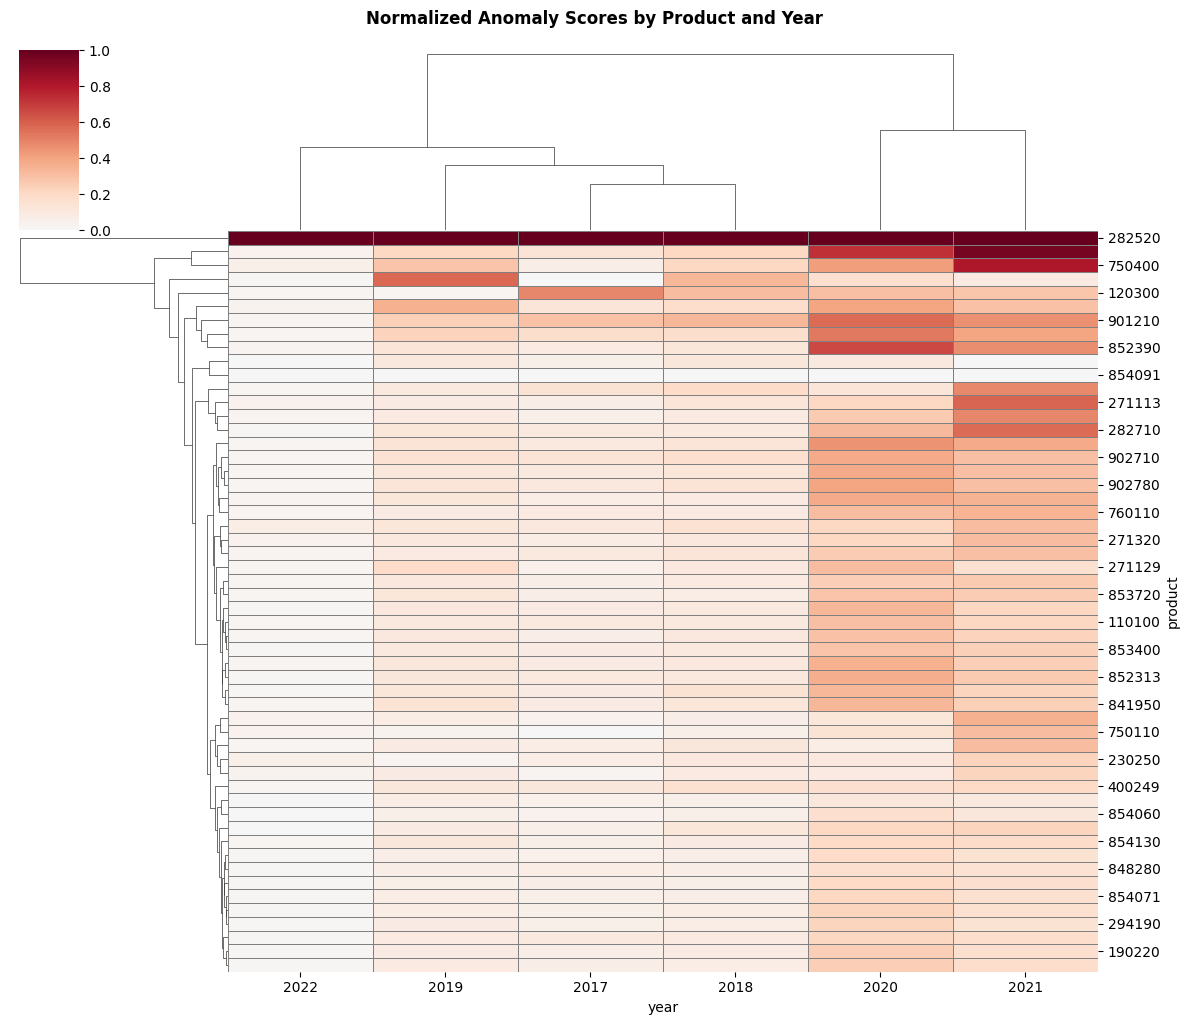

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot_df = results_df.pivot(
    index="product",
    columns="year",
    values="normalized_anomaly_score"
)

g = sns.clustermap(
    pivot_df, 
    cmap="RdBu_r",   
    center=0,         
    metric="euclidean",
    method="average",
    standard_scale=1, 
    linewidths=0.5, 
    linecolor='gray', 
    figsize=(12, 10)
)

plt.suptitle("Normalized Anomaly Scores by Product and Year", y=1.02, fontweight="bold")
plt.show()

In [ ]:
from joblib import Parallel, delayed

###################################################
# Parallelized Product-Year Loop (still super slow)
# + constantly leading to memory overflow
###################################################
all_years = df.select(pl.col("t")).unique().to_series().to_list()
all_products = df.select(pl.col("k")).unique().to_series().to_list()

############################################
# MANUAL OVERWRITE TO SAVE COMPUTE
start_year = 2017

all_products = [
    
    ##########################
    # Anomalous Candidates
    ##########################
    854060,  # Tubes: cathode ray
    854091,  # Parts of cathode-ray tubes
    854129,  # Transistors (dissipation 1W or more)
    854121,  # Transistors (dissipation <1W)
    854130,  # Thyristors, diacs, triacs
    854071,  # Tubes: microwave, magnetrons
    852313,  # Flat panel display modules
    852390,  # Parts for apparatus of heading 8524 to 8528
    853720,  # Boards, panels, consoles for electricity distribution
    853530,  # Isolating & make-and-break switches (>1000 volts)
    846130,  # Machine-tools: broaching machines
    902710,  # Instruments for gas or smoke analysis
    841950,  # Heat exchange units
    847930,  # Machinery for treating wood/cork
    901210,  # Microscopes
    848240,  # Needle roller bearings
    848280,  # Other bearings
    902780,  # Instruments for measuring variables of liquids or gases
    853210,  # Electrical capacitors: power capacitors
    841229,  # Hydraulic power engines and motors
    750110,  # Nickel mattes
    720827,  # Iron or non-alloy steel, hot-rolled
    721931,  # Steel, stainless: flat-rolled
    750711,  # Nickel: tubes and pipes
    722840,  # Steel, alloy: bars and rods
    282520,  # Lithium oxide and hydroxide
    400249,  # Rubber: synthetic chloroprene
    291613,  # Methacrylic acid
    291823,  # Carboxylic acids (complex), raw materials for pharmaceuticals/chemicals
    292146,  # Amine-function compounds (complex intermediates)
    270900,  # Crude petroleum oils
    271113,  # Butanes, liquefied
    271114,  # Liquefied ethylene, propylene, etc.
    271129,  # Petroleum gases, gaseous state
    271210,  # Petroleum jelly
    271320,  # Petroleum bitumen
    270111,  # Anthracite coal
    270112,  # Bituminous coal
    282710,  # Ammonium chloride
    750400,  # Nickel powders and flakes
    294190,  # Vacinations
    760110,  # Aluminium
    853400,  # Semiconductors
    
    ##########################
    # Baseline Candidates
    ##########################
    250100,  # Salt
    170199,  # Sugars: sucrose, chemically pure
    100610,  # Cereals: rice in the husk (paddy)
    110100,  # Wheat or meslin flour
    40210,   # Milk and cream, concentrated or sweetened
    120300,  # Copra
    230250,  # Bran, sharps and residues of leguminous plants
    190220,  # Stuffed pasta, unprepared
    200799,  # Jams, fruit jellies and marmalades (other fruits)
    80450,   # Fruit: guavas, mangoes and mangosteens, fresh or dried
    300490,  # Medicine: Antibiotics
]
############################################

evaluation_years = [y for y in all_years if y >= start_year]

tasks = [(product, year) for product in all_products for year in evaluation_years]

parallel_results = Parallel(n_jobs=4, backend="loky")(
    delayed(run_for_product_year)(df, product, year, edge_feature_cols, n_folds=1, device=device)
    for product, year in tasks
)

rows = []
for (product, year), res in zip(tasks, parallel_results):
    if res != (None, None, None):
        target_mean_score, z_score, num_edges = res
        rows.append({
            "product": product,
            "year": year,
            "anomaly_score": target_mean_score,
            "normalized_anomaly_score": z_score,
            "num_edges": num_edges
        })

results_df = pd.DataFrame(rows)

#### LITHIUM ANALYSIS

In [41]:
import polars as pl
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
import torch.nn.functional as F
import networkx as nx
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

###################################################
# Parameters
###################################################
product_code = 282520
start_year = 2005
end_year = 2022
window_size = 3
epochs = 50
lr = 0.01
embedding_dim = 32
hidden_dim = 64

# Device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

###################################################
# Load and Filter Data
###################################################
df_lithium = df.filter(pl.col("k") == product_code)

all_years = sorted(df_lithium.select(pl.col("t")).unique().to_series().to_list())
years_of_interest = [y for y in all_years if start_year <= y <= end_year]

if len(years_of_interest) < 2:
    raise ValueError("Not enough years of data for temporal analysis.")

pdf_lithium = df_lithium.to_pandas()
all_countries = np.union1d(pdf_lithium['export_country'].unique(), pdf_lithium['import_country'].unique())
country_to_id = {c: i for i, c in enumerate(all_countries)}
num_nodes = len(all_countries)

Using device: cpu


In [42]:
###################################################
# Node Feature Builder
###################################################
def build_node_features_for_year(year_data, all_countries):
    # If GDP features not available, use zero features
    if 'gdpcap_o' not in year_data.columns or 'gdpcap_d' not in year_data.columns:
        node_features = np.zeros((len(all_countries), 2))
        return torch.tensor(node_features, dtype=torch.float)

    export_gdp = year_data.groupby("export_country")["gdpcap_d"].mean().to_dict()
    import_gdp = year_data.groupby("import_country")["gdpcap_o"].mean().to_dict()

    node_features = []
    for c in all_countries:
        gdp_o_val = import_gdp.get(c, 0.0)
        gdp_d_val = export_gdp.get(c, 0.0)
        node_features.append([gdp_o_val, gdp_d_val])
    return torch.tensor(node_features, dtype=torch.float)

In [43]:
###################################################
# Graph Snapshots for each Year
###################################################
edge_feature_cols = ["v"]
scaler = StandardScaler()
all_edge_attrs = pdf_lithium[edge_feature_cols].fillna(0.0)
scaler.fit(all_edge_attrs)

def build_graph_for_year(year):
    year_pdf = pdf_lithium[pdf_lithium['t'] == year]
    if year_pdf.empty:
        return Data(x=torch.zeros((num_nodes,2)), edge_index=torch.empty((2,0), dtype=torch.long))

    x = build_node_features_for_year(year_pdf, all_countries)
    src = year_pdf['export_country'].map(country_to_id)
    dst = year_pdf['import_country'].map(country_to_id)
    edge_index = torch.tensor([src.values, dst.values], dtype=torch.long)

    attrs = year_pdf[edge_feature_cols].fillna(0.0).values
    attrs = scaler.transform(attrs)
    edge_attr = torch.tensor(attrs, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

year_graphs = []
for y in years_of_interest:
    data_y = build_graph_for_year(y)
    year_graphs.append((y, data_y))

In [44]:
###################################################
# GCN Encoder
###################################################
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [45]:
###################################################
# Training for Yearly Embeddings
###################################################
year_embeddings = {}

for y, data_y in year_graphs:
    data_y = data_y.to(device)
    encoder = GCNEncoder(in_channels=data_y.x.size(1),
                         hidden_channels=hidden_dim,
                         out_channels=embedding_dim)
    model = GAE(encoder=encoder).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    rev_edge_index = torch.stack([data_y.edge_index[1], data_y.edge_index[0]], dim=0)
    full_edge_index = torch.cat([data_y.edge_index, rev_edge_index], dim=1)
    data_y.edge_index = full_edge_index

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = model.encode(data_y.x, data_y.edge_index)
        loss = model.recon_loss(z, data_y.edge_index)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        z = model.encode(data_y.x, data_y.edge_index)
    year_embeddings[y] = z.cpu().numpy()

In [46]:
###################################################
# Sliding Window Analysis of Network Structure
###################################################
def build_nx_graph_from_edges(edge_index):
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for j in range(edge_index.size(1)):
        u = edge_index[0, j].item()
        v = edge_index[1, j].item()
        G.add_edge(u, v)
    return G

window_metrics = []
for i in range(len(years_of_interest) - window_size + 1):
    window_years = years_of_interest[i:i+window_size]
    combined_edge_index = []
    for wy in window_years:
        idx = years_of_interest.index(wy)
        ei = year_graphs[idx][1].edge_index
        combined_edge_index.append(ei)
    combined_edge_index = torch.cat(combined_edge_index, dim=1)
    
    combined_edge_index = torch.unique(combined_edge_index, dim=1)
    
    G_window = build_nx_graph_from_edges(combined_edge_index)
    
    deg_centrality = nx.degree_centrality(G_window)
    bet_centrality = nx.betweenness_centrality(G_window)
    communities = nx.algorithms.community.greedy_modularity_communities(G_window)
    num_communities = len(communities)
    
    window_metrics.append({
        'start_year': window_years[0],
        'end_year': window_years[-1],
        'avg_degree_centrality': np.mean(list(deg_centrality.values())),
        'avg_betweenness_centrality': np.mean(list(bet_centrality.values())),
        'num_communities': num_communities
    })

In [47]:
window_metrics

[{'start_year': 2005,
  'end_year': 2007,
  'avg_degree_centrality': 0.03405381064955532,
  'avg_betweenness_centrality': 0.0034368357271986815,
  'num_communities': 63},
 {'start_year': 2006,
  'end_year': 2008,
  'avg_degree_centrality': 0.034504108972194074,
  'avg_betweenness_centrality': 0.0037098441353760492,
  'num_communities': 58},
 {'start_year': 2007,
  'end_year': 2009,
  'avg_degree_centrality': 0.035460992907801414,
  'avg_betweenness_centrality': 0.0040006116351548136,
  'num_communities': 54},
 {'start_year': 2008,
  'end_year': 2010,
  'avg_degree_centrality': 0.03602386581109985,
  'avg_betweenness_centrality': 0.004214322737476679,
  'num_communities': 51},
 {'start_year': 2009,
  'end_year': 2011,
  'avg_degree_centrality': 0.036980749746707196,
  'avg_betweenness_centrality': 0.003943421340167273,
  'num_communities': 52},
 {'start_year': 2010,
  'end_year': 2012,
  'avg_degree_centrality': 0.037656197230665316,
  'avg_betweenness_centrality': 0.003900077116597767,

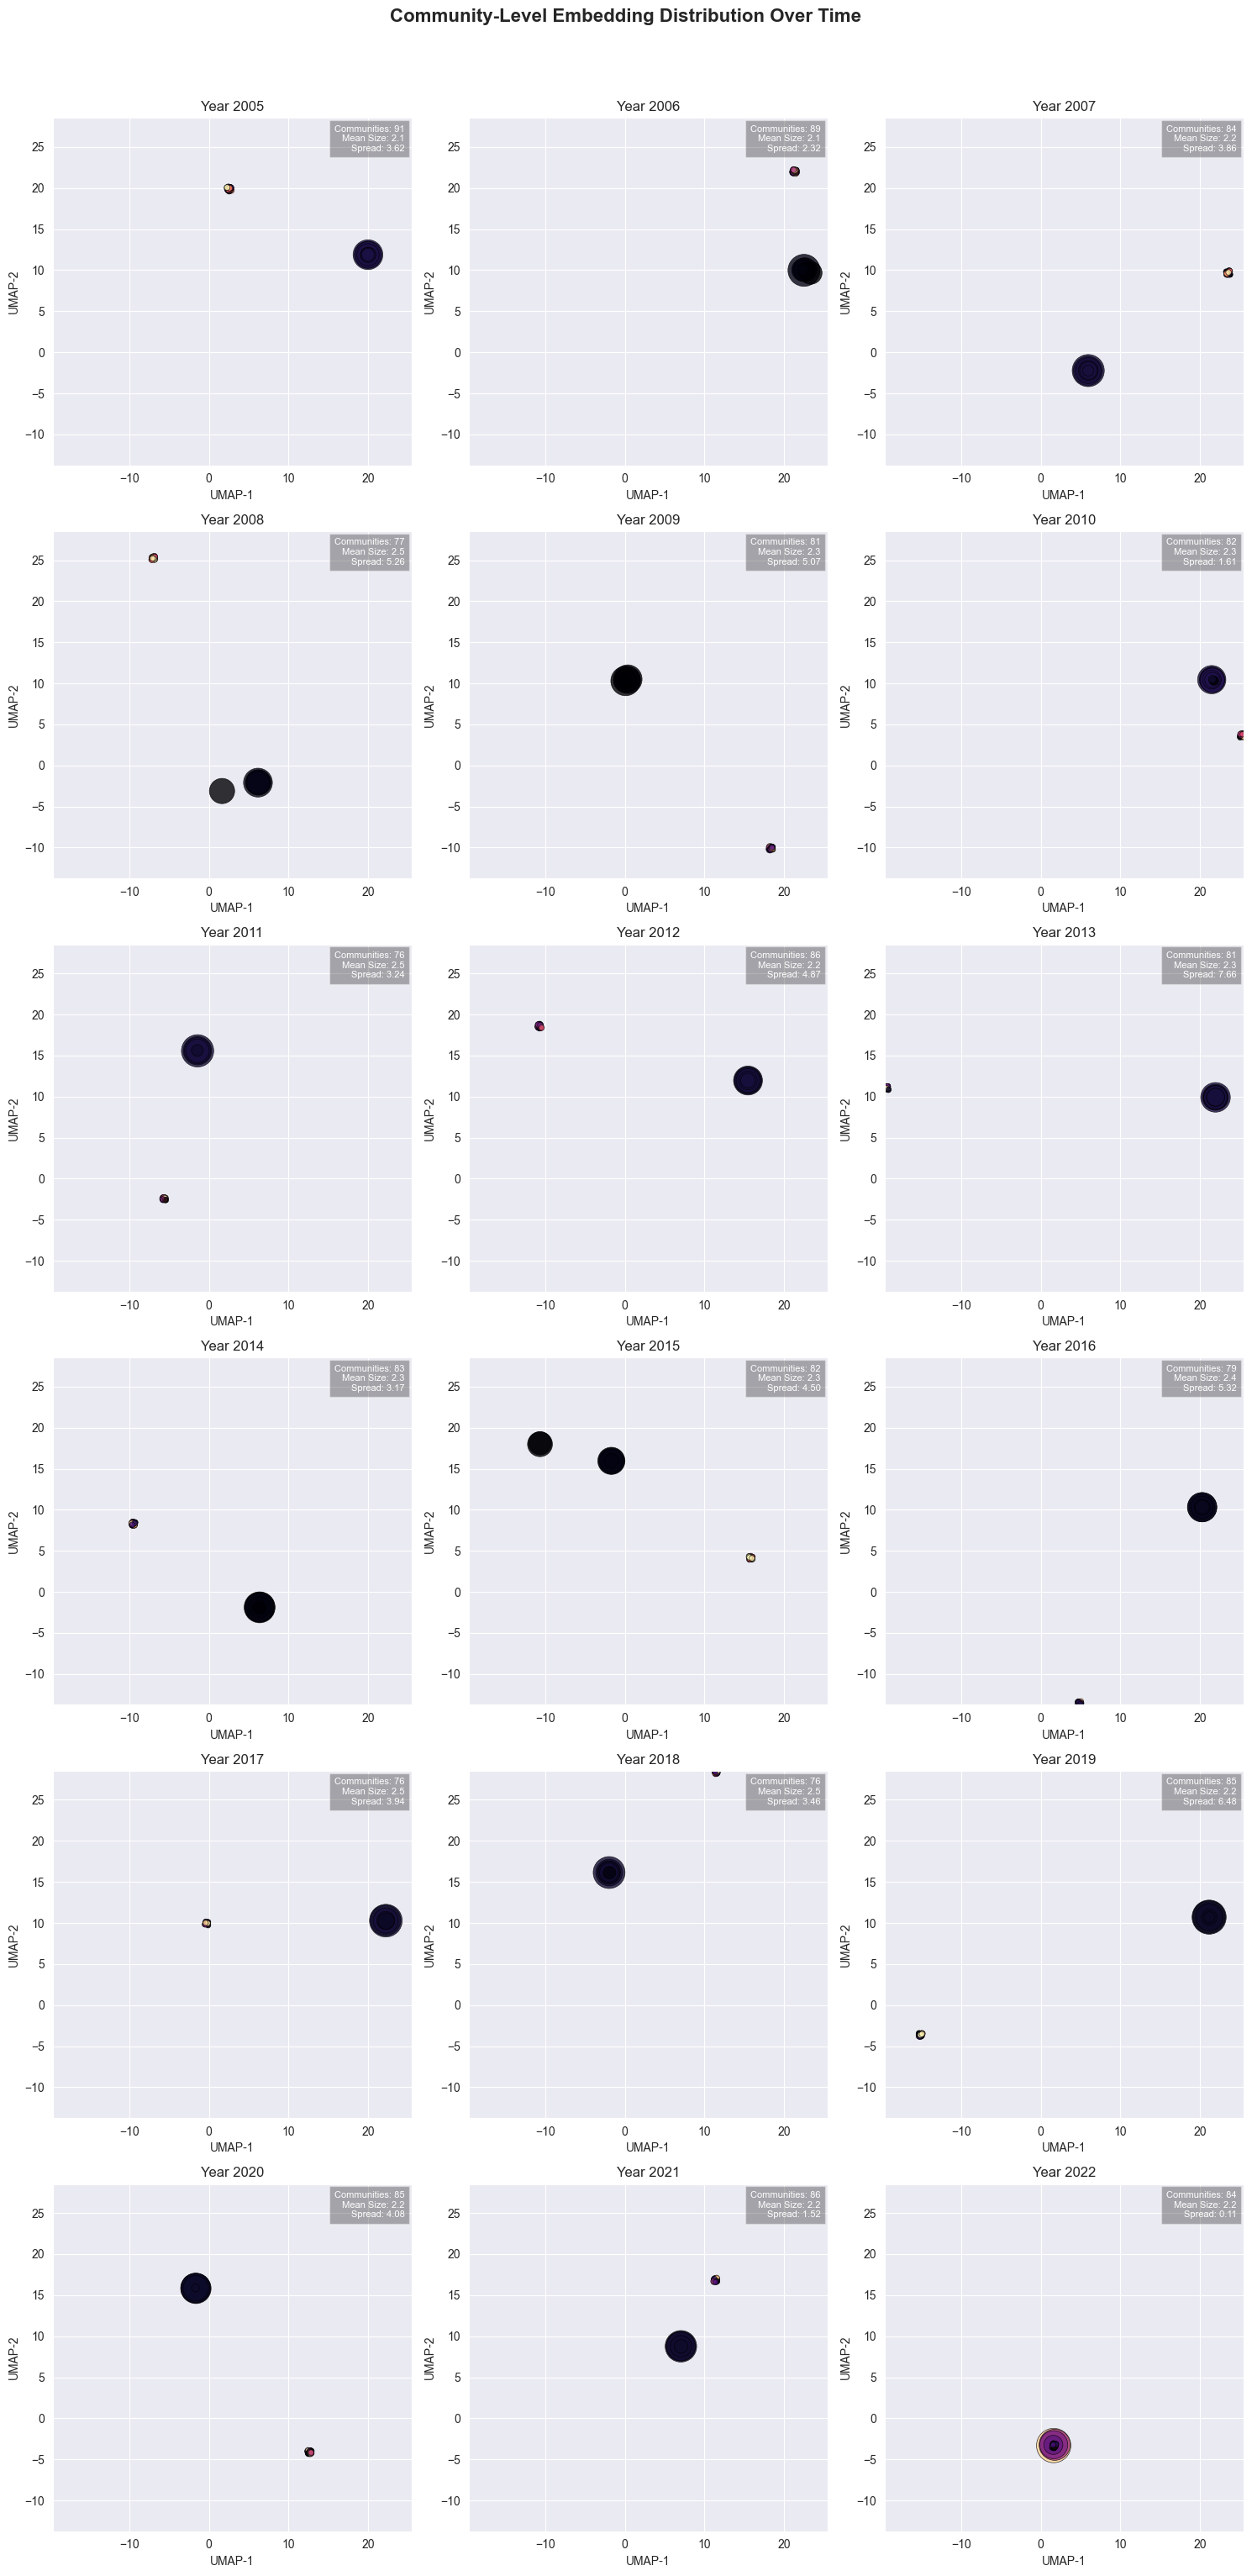

In [48]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from scipy.stats import gaussian_kde

num_nodes = len(all_countries)
embedding_dim = list(year_embeddings.values())[0].shape[1]

###################################################
# 1. Community Aggregation by Year
###################################################
def get_communities_for_year(data_y):
    G_y = nx.Graph()
    G_y.add_nodes_from(range(num_nodes))
    for j in range(data_y.edge_index.size(1)):
        u = data_y.edge_index[0, j].item()
        v = data_y.edge_index[1, j].item()
        G_y.add_edge(u, v)
    communities = nx.algorithms.community.greedy_modularity_communities(G_y)
    return communities

year_communities = {}
for y, data_y in year_graphs:
    year_communities[y] = get_communities_for_year(data_y)

###################################################
# Community-Level Embeddings
###################################################
year_comm_embeddings = {}
year_comm_sizes = {}
for y in years_of_interest:
    emb = year_embeddings[y]
    comms = year_communities[y]

    comm_embs = []
    comm_sizes = []
    for cset in comms:
        c_indices = list(cset)
        c_emb = emb[c_indices].mean(axis=0)
        comm_embs.append(c_emb)
        comm_sizes.append(len(c_indices))
    comm_embs = np.array(comm_embs)
    year_comm_embeddings[y] = comm_embs
    year_comm_sizes[y] = np.array(comm_sizes)

all_comm_embeddings = []
comm_labels = []
for y in years_of_interest:
    cemb = year_comm_embeddings[y]
    for i in range(cemb.shape[0]):
        all_comm_embeddings.append(cemb[i])
        comm_labels.append((y, i))

all_comm_embeddings = np.vstack(all_comm_embeddings)
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
all_comm_2d = reducer.fit_transform(all_comm_embeddings)

x_min, x_max = all_comm_2d[:,0].min(), all_comm_2d[:,0].max()
y_min, y_max = all_comm_2d[:,1].min(), all_comm_2d[:,1].max()

cols = 3
rows = math.ceil(len(years_of_interest)/cols)
fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axs = axs.flatten()

###################################################
# Plot Years Arranged in a Grid
###################################################
for idx, y in enumerate(years_of_interest):
    year_indices = [i for i, (yr, _) in enumerate(comm_labels) if yr == y]
    year_embs_2d = all_comm_2d[year_indices]
    x = year_embs_2d[:,0]
    yy = year_embs_2d[:,1]

    xy = np.vstack([x, yy])
    z = gaussian_kde(xy)(xy)
    
    comm_sizes = year_comm_sizes[y]
    size_scaled = 50 * (comm_sizes / comm_sizes.mean())

    ax = axs[idx]
    sc = ax.scatter(x, yy, c=z, cmap='magma', s=size_scaled, alpha=0.8, edgecolors='black', linewidths=0.5)
    ax.set_title(f"Year {y}", fontsize=12)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

    n_comms = len(comm_sizes)
    mean_size = comm_sizes.mean()
    spread = np.sqrt((x.var() + yy.var())/2.0)

    summary_text = (f"Communities: {n_comms}\n"
                    f"Mean Size: {mean_size:.1f}\n"
                    f"Spread: {spread:.2f}")
    ax.text(0.98, 0.98, summary_text, transform=ax.transAxes, 
            va='top', ha='right', fontsize=8,
            bbox=dict(facecolor='black', alpha=0.3, pad=4),
            color='white')

for i in range(len(years_of_interest), len(axs)):
    fig.delaxes(axs[i])

fig.suptitle("Community-Level Embedding Distribution Over Time", fontsize=16, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()



posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


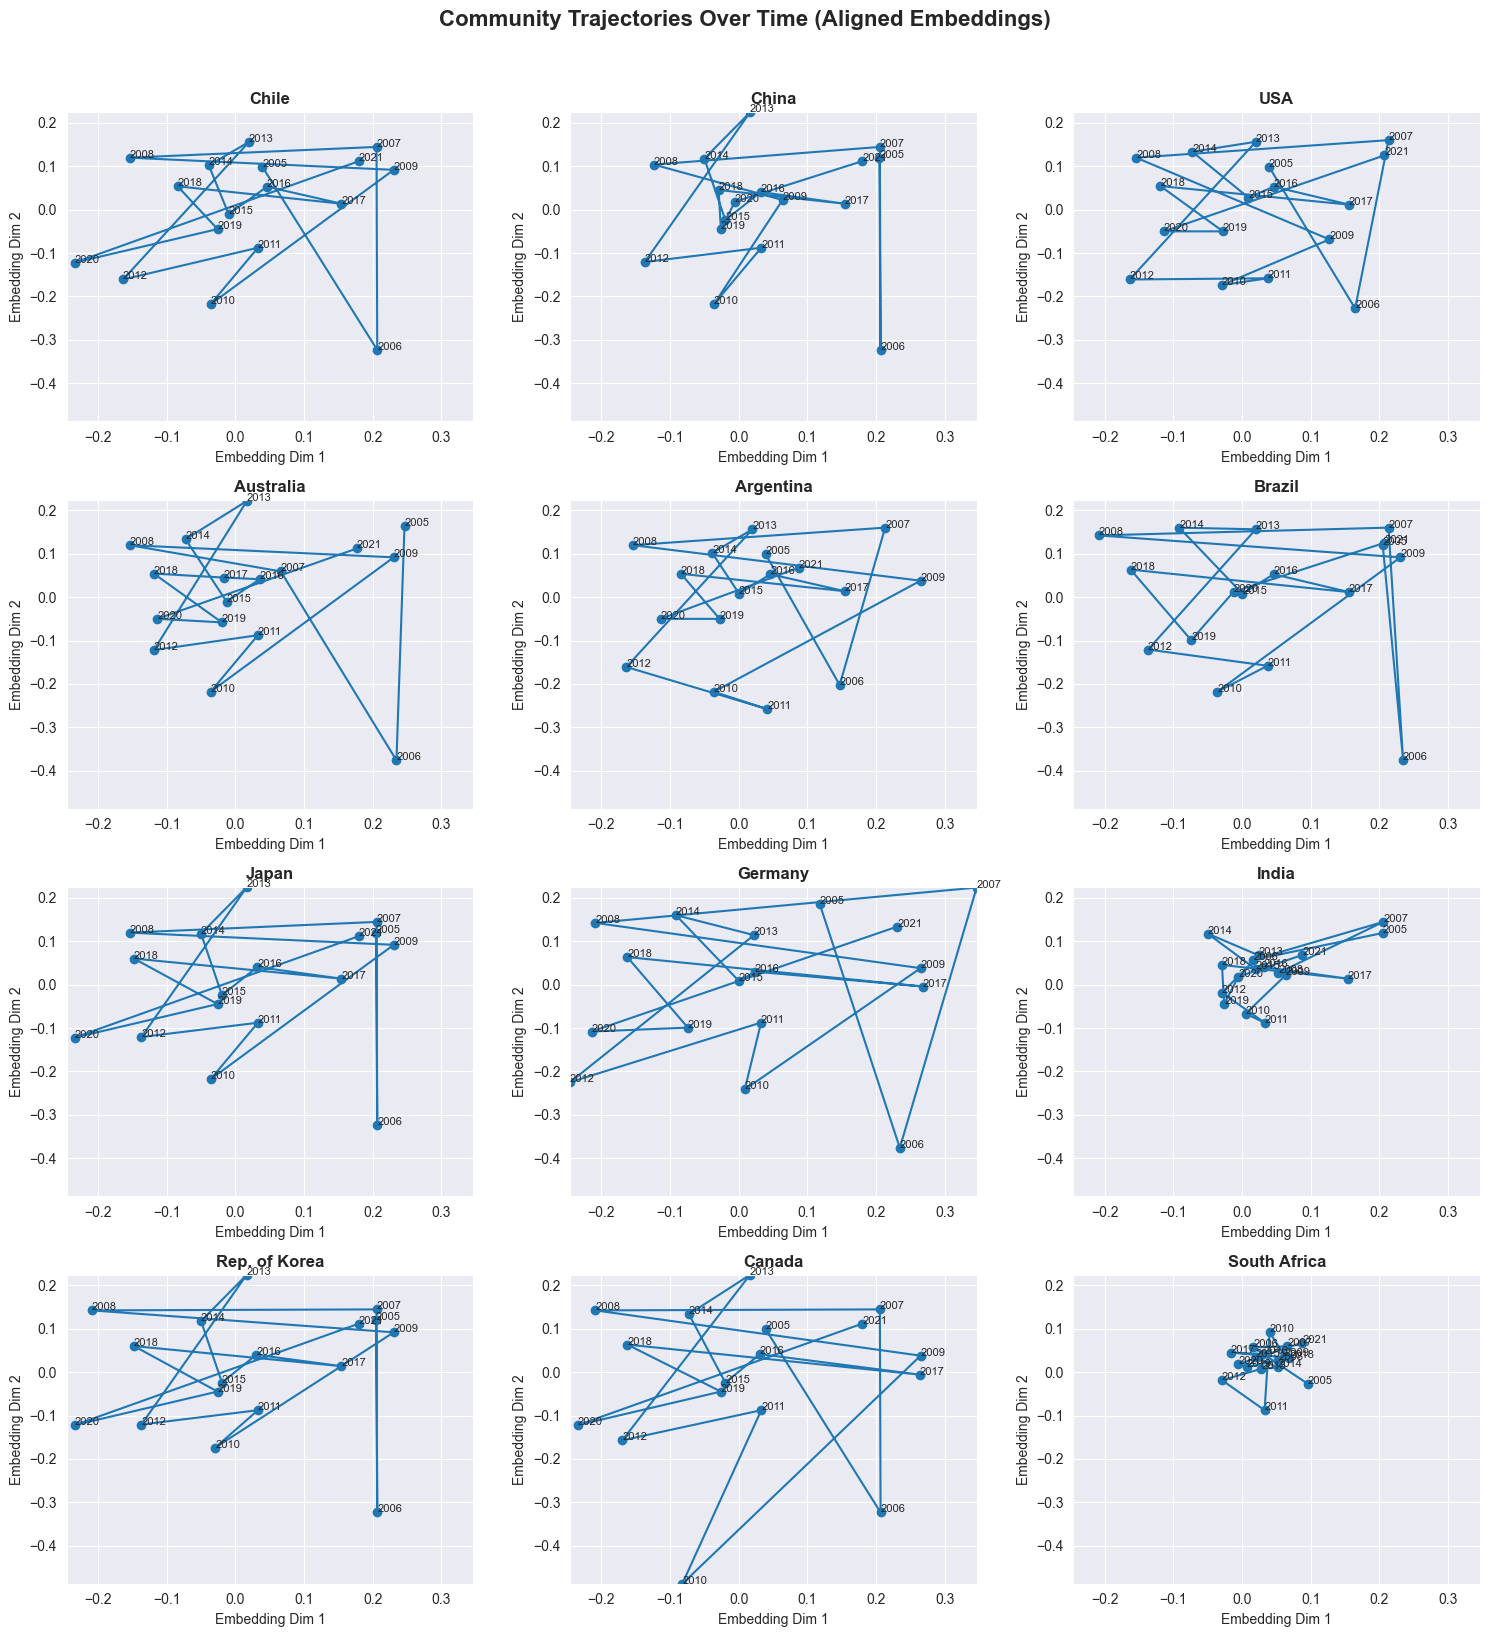

In [52]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

num_nodes = len(all_countries)
embedding_dim = 32
hidden_dim = 64
epochs = 50
lr = 0.01

def build_graph_for_year(year):
    year_pdf = pdf_lithium[pdf_lithium['t'] == year]
    if year_pdf.empty:
        data = Data(x=torch.zeros((num_nodes, 2)), edge_index=torch.empty((2,0), dtype=torch.long))
        return data

    x = build_node_features_for_year(year_pdf, all_countries)
    src = year_pdf['export_country'].map(country_to_id)
    dst = year_pdf['import_country'].map(country_to_id)
    edge_index = torch.tensor([src.values, dst.values], dtype=torch.long)

    attrs = year_pdf[edge_feature_cols].fillna(0.0).values
    attrs = scaler.transform(attrs)
    edge_attr = torch.tensor(attrs, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

year_graphs = []
for y in years_of_interest:
    year_graphs.append((y, build_graph_for_year(y)))

##############################################
# GCN Encoder for GAE
##############################################
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

##############################################
# Training
##############################################
year_embeddings = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Couldn't make mps work here for some reason

for y, data_y in year_graphs:
    data_y = data_y.to(device)

    encoder = GCNEncoder(in_channels=data_y.x.size(1), hidden_channels=hidden_dim, out_channels=embedding_dim)
    model = GAE(encoder=encoder).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    rev_edge_index = torch.stack([data_y.edge_index[1], data_y.edge_index[0]], dim=0)
    full_edge_index = torch.cat([data_y.edge_index, rev_edge_index], dim=1)
    data_y.edge_index = full_edge_index

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = model.encode(data_y.x, data_y.edge_index)
        loss = model.recon_loss(z, data_y.edge_index)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        z = model.encode(data_y.x, data_y.edge_index)
    year_embeddings[y] = z.cpu().numpy()

##############################################
# Alignment of Embeddings over Time
##############################################
def align_embeddings(ref_emb, target_emb):
    ref_mean = ref_emb.mean(axis=0, keepdims=True)
    tgt_mean = target_emb.mean(axis=0, keepdims=True)
    ref_centered = ref_emb - ref_mean
    tgt_centered = target_emb - tgt_mean
    U, S, Vt = np.linalg.svd(ref_centered.T @ tgt_centered)
    R = U @ Vt
    aligned = (tgt_centered @ R)
    aligned *= (np.linalg.norm(ref_centered) / np.linalg.norm(aligned))
    aligned += ref_mean
    return aligned

ref_year = years_of_interest[0]
ref_emb = year_embeddings[ref_year]
for y in years_of_interest[1:]:
    year_embeddings[y] = align_embeddings(ref_emb, year_embeddings[y])

##############################################
# Community Detection and Tracking
##############################################
year_communities = {}
for y, data_y in year_graphs:
    ei = data_y.edge_index.cpu().numpy() if data_y.edge_index.numel() > 0 else np.empty((2,0),dtype=int)
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for j in range(ei.shape[1]):
        G.add_edge(ei[0,j], ei[1,j])
    comms = nx.algorithms.community.greedy_modularity_communities(G)
    year_communities[y] = comms

def find_community_for_country(comms, cid):
    for i, cset in enumerate(comms):
        if cid in cset:
            return i
    return None

##############################################
# Visualization of Country Trajectory
##############################################
key_countries = [
    "Chile", "China", "USA", "Australia", "Argentina", 
    "Brazil", "Japan", "Germany", "India", "Rep. of Korea", 
    "Canada", "South Africa"
]

country_ids = {c: country_to_id[c] for c in key_countries if c in country_to_id}

country_trajectories = {}
all_coords = []

for ctry, cid in country_ids.items():
    community_positions_over_time = []
    for y in years_of_interest:
        comms = year_communities[y]
        c_idx = find_community_for_country(comms, cid)
        if c_idx is not None:
            emb = year_embeddings[y]
            c_indices = list(comms[c_idx])
            c_position = emb[c_indices].mean(axis=0)
            community_positions_over_time.append((y, c_position))
    country_trajectories[ctry] = community_positions_over_time

    if len(community_positions_over_time) > 0:
        _, coords = zip(*community_positions_over_time)
        coords = np.array(coords)
        all_coords.append(coords)

if len(all_coords) > 0:
    all_coords_stacked = np.vstack(all_coords)
    x_min = np.nanmin(all_coords_stacked[:,0])
    x_max = np.nanmax(all_coords_stacked[:,0])
    y_min = np.nanmin(all_coords_stacked[:,1])
    y_max = np.nanmax(all_coords_stacked[:,1])
    
else:
    x_min, x_max, y_min, y_max = -1, 1, -1, 1

num_countries = len(country_trajectories)
cols = 3
rows = (num_countries + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axs = axs.flatten()

for i, (ctry, traj) in enumerate(country_trajectories.items()):
    ax = axs[i]
    if len(traj) > 0:
        ys, coords = zip(*traj)
        coords = np.array(coords)
        ax.plot(coords[:,0], coords[:,1], marker='o')
        for j, yy in enumerate(ys):
            ax.text(coords[j,0], coords[j,1], str(yy), fontsize=8)

        ax.set_title(f"{ctry}", fontweight="bold")
        ax.set_xlabel("Embedding Dim 1")
        ax.set_ylabel("Embedding Dim 2")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    else:
        ax.text(0.5,0.5,"No Data",ha='center',va='center',fontsize=10)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel("Embedding Dim 1")
        ax.set_ylabel("Embedding Dim 2")

for k in range(num_countries, rows*cols):
    fig.delaxes(axs[k])

fig.suptitle("Community Trajectories Over Time (Aligned Embeddings)", fontsize=16, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()